In [ ]:
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict
import random
import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import ipywidgets
from IPython import display
from torch.autograd import Variable
from torchvision.io import read_image
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from datetime import datetime, timedelta
import pytz
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
selfie_train_path = '/content/drive/MyDrive/Computer Vision/selfie2anime/Atrain'
selfie_test_path = '/content/drive/MyDrive/Computer Vision/selfie2anime/Atest'
anime_train_path = '/content/drive/MyDrive/Computer Vision/selfie2anime/Btrain'
anime_test_path = '/content/drive/MyDrive/Computer Vision/selfie2anime/Btest'

In [ ]:
if torch.cuda.is_available():
  print("USING GPU")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

USING GPU


# Data Analysis

In [ ]:
import PIL
from PIL import Image
img = PIL.Image.open("/content/drive/MyDrive/Computer Vision/selfie2anime/Atrain/trainA/female_10.jpg")
w, h = img.size
print("Selfie Train Res")
print(str(w) + "x" + str(h) + "\n")

img = PIL.Image.open("/content/drive/MyDrive/Computer Vision/selfie2anime/Btrain/trainB/0000.jpg")
w, h = img.size
print("Anime Train Res")
print(str(w) + "x" + str(h) + "\n")

Selfie Train Res
256x256

Selfie Test Res
256x256

Anime Train Res
256x256

Anime Test Res
256x256



torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


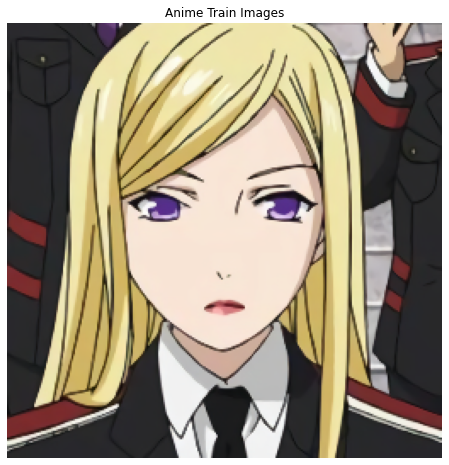

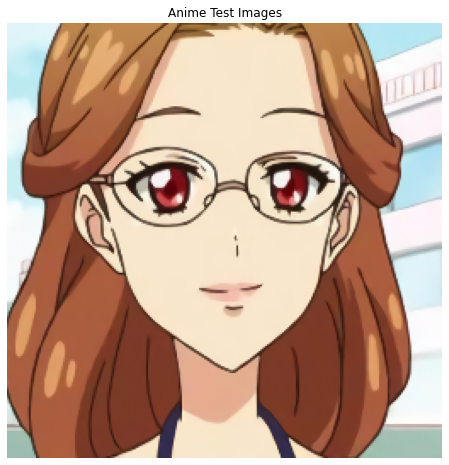

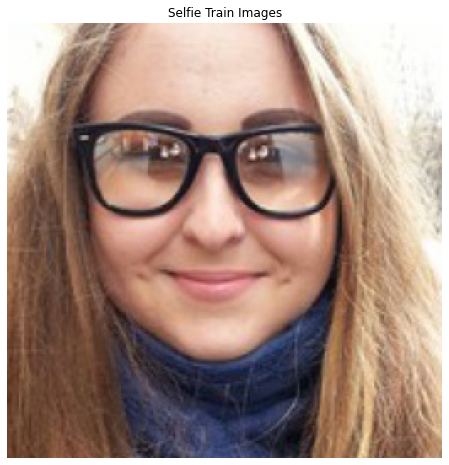

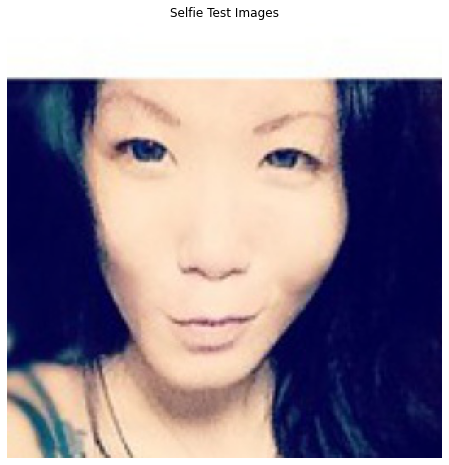

In [ ]:
path_trainA = '/content/drive/MyDrive/Computer Vision/selfie2anime/Atrain/'
path_trainB = '/content/drive/MyDrive/Computer Vision/selfie2anime/Btrain/'
path_testA = '/content/drive/MyDrive/Computer Vision/selfie2anime/Atest/'
path_testB = '/content/drive/MyDrive/Computer Vision/selfie2anime/Btest/'

batch_size = 1
num_workers = 1
imgtransform = T.Compose(
    [
        T.Resize(256),
        T.ToTensor(),
        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]
                )
trainA_set = dset.ImageFolder(path_trainA, transform=imgtransform)
trainB_set = dset.ImageFolder(path_trainB, transform=imgtransform)
testA_set = dset.ImageFolder(path_testA, transform=imgtransform)
testB_set = dset.ImageFolder(path_testB, transform=imgtransform)

loader_trainA = DataLoader(trainA_set, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers)
loader_trainB = DataLoader(trainB_set, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers)
loader_testA = DataLoader(testA_set, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers)
loader_testB = DataLoader(testB_set, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers)

loaders = [loader_trainB, loader_testB, loader_trainA, loader_testA]

def plot_train_test(loaders, transform, batch_size):
  labels = ['Anime Train Images', 'Anime Test Images', 'Selfie Train Images', 'Selfie Test Images']
  for i, data in enumerate(loaders):
    real_batch = next(iter(data))
    print(real_batch[0].shape)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(labels[i])
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

plot_train_test(loaders, imgtransform, 5)

trainA = os.listdir(path_trainA + "/trainA")
trainB = os.listdir(path_trainB + "/trainB")
testA = os.listdir(path_testA + "/testA")
testB = os.listdir(path_testB + "/testB")

print(f"Selfie Train Data Size: {len(trainA)}")
print(f"Anime Train Data Size: {len(trainB)}")
print(f"Selfie Test Data Size: {len(testA)}")
print(f"Anime Test Data Size: {len(testB)}")

# Modeling

In [ ]:
class Resnet(nn.Module):
    def __init__(self, dim):
        super(Resnet, self).__init__()
        self.model = nn.Sequential(
            #[1, 256, 64, 64]
            nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3,
                      stride = 1, padding = 1),
            nn.InstanceNorm2d(dim),
            nn.ReLU(),
            nn. Dropout(),
            nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=3,
                      stride=1, padding=1),
            nn.InstanceNorm2d(dim)
            #[1, 256, 64, 64]
        )
    def forward(self, x):
        return x + self.model(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, dim):
        super(Generator, self).__init__()
        self.encode = nn.Sequential(
            #[1, 3, 256, 256]
            nn.ReflectionPad2d(3), #[1, 3, 262, 262]
            nn.Conv2d(in_channels=3, out_channels=dim, kernel_size=7,
                      stride=1, padding=0), #[1, 64, 256, 256]
            nn.InstanceNorm2d(dim), #[1, 64, 256, 256]
            nn.ReLU(True), #[1, 64, 256, 256]
            nn.Conv2d(in_channels=dim, out_channels=dim*2, kernel_size=3,
                      stride=2, padding=1), #[1, 128, 128, 128]
            nn.InstanceNorm2d(dim*2), #[1, 128, 128, 128]
            nn.ReLU(True), #[1, 128, 128, 128]
            nn.Conv2d(in_channels=dim*2, out_channels=dim*4, kernel_size=3,
                      stride=2, padding=1), #[1, 256, 64, 64]
            nn.InstanceNorm2d(dim*4), #[1, 256, 64, 64]
            nn.ReLU(True) #[1, 256, 64, 64]
            )
        self.res = nn.Sequential(
            #[1, 256, 64, 64]
            Resnet(dim*4), Resnet(dim*4), Resnet(dim*4),
            Resnet(dim*4), Resnet(dim*4), Resnet(dim*4)
            #[1, 256, 64, 64]
        )
        self.decode = nn.Sequential(
            #[1, 256, 64, 64]
            nn.ConvTranspose2d(in_channels=dim*4, out_channels=dim*2, kernel_size=3,
                               stride=2, padding=1, output_padding=1), #[1, 128, 128, 128]
            nn.InstanceNorm2d(dim*2), #[1, 128, 128, 128]
            nn.ReLU(True), #[1, 128, 128, 128]
            nn.ConvTranspose2d(in_channels=dim*2, out_channels=dim, kernel_size=3,
                               stride=2, padding=1, output_padding=1), #[1, 64, 256, 256]
            nn.InstanceNorm2d(dim), #[1, 64, 256, 256]
            nn.ReLU(True), #[1, 64, 256, 256]
            nn.ReflectionPad2d(3), #[1, 64, 262, 262]
            nn.Conv2d(in_channels=dim, out_channels=3, kernel_size=7,
                        stride=1, padding=0), #[1, 3, 256, 256]
            nn.Tanh() #[1, 3, 256, 256]
        )
    def forward(self, x):
        out1 = self.encode(x)
        #print(out1.size())
        out2 = self.res(out1)
        #print(out2.size())
        out3 = self.decode(out2)
        #print(out3.size())
        return out3

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            #input size = [1, 3, 256, 256]
            nn.Conv2d(in_channels=3, out_channels=dim, kernel_size=4,
                      stride=2, padding=1, bias=False),  #[1, 64, 128, 128]
            nn.LeakyReLU(0.2, True),  #[1, 64, 128, 128]
            #input size = [1, 64, 128, 128]
            nn.Conv2d(in_channels=dim, out_channels=dim*2, kernel_size=4,
                      stride=2, padding=1, bias=False), #[1, 128, 64, 64]
            nn.InstanceNorm2d(dim*2), #[1, 128, 64, 64]
            nn.LeakyReLU(0.2, True), #[1, 128, 64, 64]
            #input size = [1, 128, 64, 64]
            nn.Conv2d(in_channels=dim*2, out_channels=dim*4, kernel_size=4,
                      stride=2, padding=1, bias=False), #[1, 256, 32, 32]
            nn.InstanceNorm2d(dim*4), #[1, 256, 32, 32]
            nn.LeakyReLU(0.2, True), #[1, 256, 32, 32]
            #input size = [1, 256, 32, 32]
            nn.Conv2d(in_channels=dim*4, out_channels=dim*8, kernel_size=4,
                      stride=1, padding=1, bias=False), #[1, 512, 31, 31]
            nn.InstanceNorm2d(dim*8), #[1, 512, 31, 31]
            nn.LeakyReLU(0.2, True), #[1, 512, 31, 31]
            #input size = [1, 512, 31, 31]
            nn.Conv2d(in_channels=dim*8, out_channels=3, kernel_size=4,
                      stride=1, padding=1) #[1, 3, 30, 30]
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
#def LGAN_D(real, fake):
#    return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LGAN_G(fake):
    return  torch.mean((fake - 1)**2)
#criterion_Im = torch.nn.L1Loss()
# Learning rate for optimizers
#lr = 0.0002

# Beta1 hyperparam for Adam optimizers
#beta1 = 0.5

In [ ]:
SAVE_PATH = "/content/drive/MyDrive/Computer Vision/saved/"

def save_model(gen_f2a, gen_a2f, dis_face, dis_anime, dir_path, gen_f2a_opt, gen_a2f_opt, dis_f_opt, dis_a_opt):

  if not (os.path.isdir(dir_path) or os.path.isfile(dir_path)):
    dic = {
        # "epoch_loss" : checkpoint_loss,
        "gen_f2a" : gen_f2a.state_dict(),
        "gen_a2f" : gen_a2f.state_dict(),
        "dis_face" : dis_face.state_dict(),
        "dis_anime" : dis_anime.state_dict(),
        "gen_f2a_opt" : gen_f2a_opt.state_dict(),
        "gen_a2f_opt" : gen_a2f_opt.state_dict(),
        "dis_f_opt" : dis_f_opt.state_dict(),
        "dis_a_opt" : dis_a_opt.state_dict(),
    }

    torch.save(dic, dir_path)

  else:
    dir_path = dir_path + "Temp.pt"
    dic = {
        # "epoch_loss" : checkpoint_loss,
        "gen_f2a" : gen_f2a.state_dict(),
        "gen_a2f" : gen_a2f.state_dict(),
        "dis_face" : dis_face.state_dict(),
        "dis_anime" : dis_anime.state_dict(),
        "gen_f2a_opt" : gen_f2a_opt.state_dict(),
        "gen_a2f_opt" : gen_a2f_opt.state_dict(),
        "dis_f_opt" : dis_f_opt.state_dict(),
        "dis_a_opt" : dis_a_opt.state_dict(),
    }

    torch.save(dic, dir_path)




In [ ]:
def randompool(fakelst, current_fake):
    '''
    Helper function for training, keeps a list of fake pics
    for discriminator.
    '''
    if len(fakelst) < 20:
        fakelst.append(current_fake)
        output = current_fake
    else:
        if np.random.ranf() > 0.5:
            ind = np.random.randint(0, 20)
            output = fakelst[ind].copy()
            fakelst[ind] = current_fake
        else:
            output = current_fake
    return fakelst, output

In [ ]:
def epoch_plot(gen1, gen2, loaderA, loaderB, epoch, save_path, save_all=False):
    loaded_face = loaderA.dataset[3][0]
    face_input = loaded_face.unsqueeze(0).to(device)
    animed_face = gen1(face_input).to(device)
    back_face = gen2(animed_face).to(device)
    img_grid = torch.cat((face_input, animed_face, back_face), dim=0)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    title = f"Epoch {epoch}: Selfie to Anime to Selfie"
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(img_grid.to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

    random = np.random.randint(0, 100)
    loaded_face = loaderA.dataset[random][0]
    face_input = loaded_face.unsqueeze(0).to(device)
    animed_face = gen1(face_input).to(device)
    back_face = gen2(animed_face).to(device)
    img_grid = torch.cat((face_input, animed_face, back_face), dim=0)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    title = f"Epoch {epoch}: Random (Index {random}) Selfie to Anime to Selfie"
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(img_grid.to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()


    if save_all:
        for i in range(50):
            loaded_face = loaderA.dataset[i][0]
            face_input = loaded_face.unsqueeze(0).to(device)
            animed_face = gen1(face_input).to(device)
            back_face = gen2(animed_face).to(device)
            img_grid = torch.cat((face_input, animed_face, back_face), dim=0)
            plt.figure(figsize=(8,8))
            plt.axis("off")
            # title = f"(Index {i}) Selfie to Anime to Selfie"
            title = "Selfie to Anime to Selfie"
            plt.title(title)
            plt.imshow(np.transpose(vutils.make_grid(img_grid.to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))
            path = save_path + f"Figure {i}.png"

            # bbox_inches = "tight" to save space
            plt.savefig(path, dpi = 300)


# Training

In [ ]:
params = {
    'batch_size':1,
    'num_epochs':50,
    'lr':0.0002,    #learning rate for generator/discriminator
    'lambda':10   #lambda for cycle loss
}

MSE_Loss = torch.nn.MSELoss().cuda()
L1_Loss = torch.nn.L1Loss().cuda()
G_A = Generator(64).to(device)
G_B = Generator(64).to(device)
D_A = Discriminator(64).to(device)
D_B = Discriminator(64).to(device)

G_optimizer = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=params['lr'], betas=(0.5, 0.999))
D_A_optimizer = torch.optim.Adam(D_A.parameters(), lr=params['lr'], betas=(0.5, 0.999))
D_B_optimizer = torch.optim.Adam(D_B.parameters(), lr=params['lr'], betas=(0.5, 0.999))

random_pool_face = []
random_pool_anime = []

step = 0

random = np.random.randint(0, 99)

In [ ]:
# start timer
CT = pytz.timezone('US/Central')
now = datetime.now(CT)
current_time = now.strftime("%H:%M:%S")
print(f"CURRENT TIME CST = {current_time}")
start_time = time.time()
times = []

for epoch in range(params['num_epochs']):
    # start epoch timer
    start_epoch = time.time()
    # training
    for i, (real_A, real_B) in enumerate(zip(loader_trainA, loader_trainB)):
        # input image data
        real_face = real_A[0].to(device)
        real_anime = real_B[0].to(device)

        ###### Generator Training (face to anime and anime to face) ######
        ### face to anime generator loss
        ### Want to trick discriminator so want mse loss below to be small
        fake_anime = G_A(real_face)
        D_B_fake_decision = D_B(fake_anime)
        G_A_loss = MSE_Loss(D_B_fake_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))
        ### face to anime to face cycle loss
        ### Want face to become face again so want below loss to be small
        back2face = G_B(fake_anime)
        face_cycle_loss = L1_Loss(back2face, real_face) * params['lambda']
        ### anime to face generator loss
        ### Want to trick discriminator so want mse loss below to be small
        fake_face = G_B(real_anime)
        D_A_fake_decision = D_A(fake_face)
        G_B_loss = MSE_Loss(D_A_fake_decision, Variable(torch.ones(D_A_fake_decision.size()).cuda()))
        ### anime to face to anime cycle loss
        ### Want anime to become anime again so want below loss to be small
        back2anime = G_A(fake_face)
        anime_cycle_loss = L1_Loss(back2anime, real_anime) * params['lambda']
        ### Backprop of sum of losses
        G_loss = G_A_loss + G_B_loss + face_cycle_loss + anime_cycle_loss
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        ###### Face Discriminator Training ######
        ### When predicting real label should be 1 so
        ### below finds diff between 1 and predicted label for real
        D_A_real_decision = D_A(real_face)
        D_A_real_loss = MSE_Loss(D_A_real_decision, Variable(torch.ones(D_A_real_decision.size()).cuda()))
        ### Tests from historical fake data to prevent mode collapse
        ### samples from random historical fake face data
        random_pool_face, out_fake_face = randompool(random_pool_face, fake_face.cpu().data.numpy())
        fake_face = torch.Tensor(out_fake_face).to(device)
        ### When predicting fake label should be 0 so
        ### below finds diff between 0 and predicted label for fake
        D_A_fake_decision = D_A(fake_face)
        D_A_fake_loss = MSE_Loss(D_A_fake_decision, Variable(torch.zeros(D_A_fake_decision.size()).cuda()))
        ### Backprop
        D_A_loss = (D_A_real_loss + D_A_fake_loss) * 0.5
        D_A_optimizer.zero_grad()
        D_A_loss.backward()
        D_A_optimizer.step()
        ###### Anime Discriminator Training ######
        ### When predicting real label should be 1 so
        ### below finds diff between 1 and predicted label for real
        D_B_real_decision = D_B(real_anime)
        D_B_real_loss = MSE_Loss(D_B_real_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))
        ### Tests from historical fake data to prevent mode collapse
        ### samples from random historical fake anime data
        random_pool_anime, out_fake_anime = randompool(random_pool_anime, fake_anime.cpu().data.numpy())
        fake_anime = torch.Tensor(out_fake_anime).to(device)
        ### When predicting fake label should be 0 so
        ### below finds diff between 0 and predicted label for fake
        D_B_fake_decision = D_B(fake_anime)
        D_B_fake_loss = MSE_Loss(D_B_fake_decision, Variable(torch.zeros(D_B_fake_decision.size()).cuda()))
        ### Backprop
        D_B_loss = (D_B_real_loss + D_B_fake_loss) * 0.5
        D_B_optimizer.zero_grad()
        D_B_loss.backward()
        D_B_optimizer.step()

        # PRINT PROGRESS
        if i%100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], D_A_loss: %.4f, D_B_loss: %.4f, G_A_loss: %.4f, G_B_loss: %.4f'
                  % (epoch+1, params['num_epochs'], i+1, len(loader_trainA), D_A_loss.item(), D_B_loss.item(), G_A_loss.item(), G_B_loss.item()))
        step += 1
    FIG_SAVE = "/content/drive/MyDrive/Computer Vision/saved/Figures"
    epoch_plot(G_A, G_B, loader_testA, loader_testB, epoch, FIG_SAVE, save_all=False)

    SAVE_PATH = f"/content/drive/MyDrive/Computer Vision/saved/Epoch {epoch}.pt"

    epoch_loss = {}
    #save_model(gen_f2a, gen_a2f, dis_face, dis_anime, SAVE_PATH, epoch_loss, G_opt_face2anime, G_opt_anime2face, D_opt_face, D_opt_anime)
    save_model(G_A, G_B, D_A, D_B, SAVE_PATH, epoch_loss, G_optimizer, G_optimizer, D_A_optimizer, D_B_optimizer)
    # end epoch timer
    end_epoch = time.time()
    elapsed_time = end_epoch - start_time
    full_epoch_time = str(timedelta(seconds = elapsed_time)).split(".")[0]
    print(f"Elapsed Time at Epoch {epoch + 1}: {full_epoch_time}")
    times.append(elapsed_time)

# display final times
final_time = time.time()
avg_time = (sum(times) / params['num_epochs']) / 60
print(f"Average Epoch Time: {avg_time:.2f}")

end_time = time.time()
full_time = end_time - start_time
full_time = str(timedelta(seconds=full_time)).split(".")[0]
print(f"Full Time: {full_time}")

end = datetime.now()
ending_time = end.strftime("%H:%M:%S")
print(f"Final Time: {ending_time}")

# Loading Model

In [ ]:
LATEST_SAVED = "/content/drive/MyDrive/Computer Vision/saved/Epoch 49.pt"
model = torch.load(LATEST_SAVED)
G_A = Generator(64).to(device)
G_A.load_state_dict(model['gen_f2a'])
G_B = Generator(64).to(device)
G_B.load_state_dict(model['gen_a2f'])

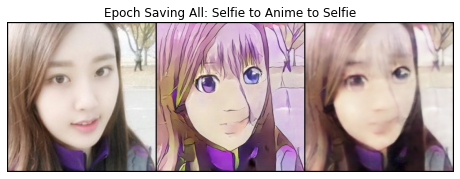

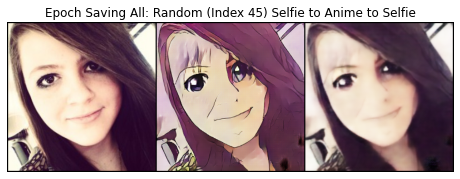

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


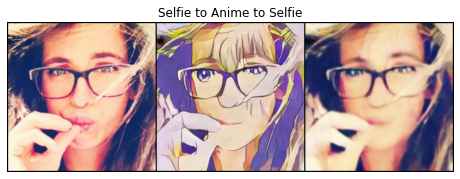

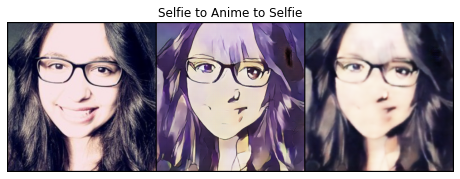

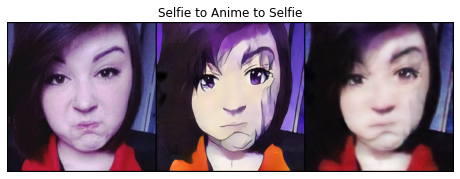

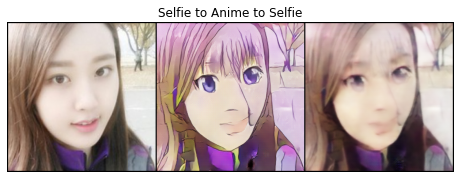

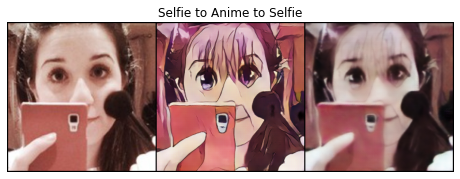

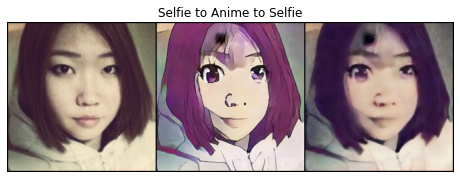

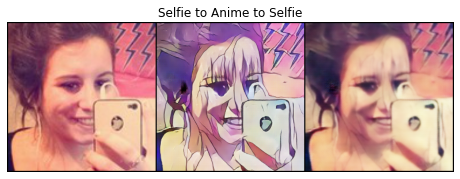

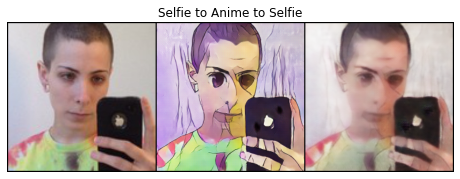

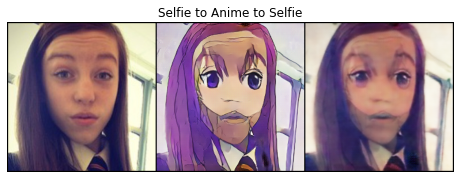

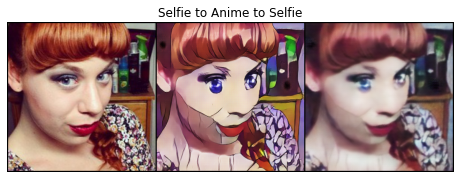

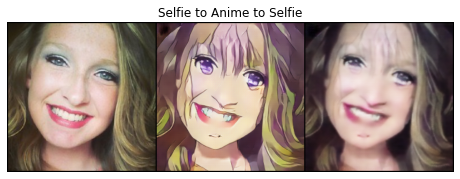

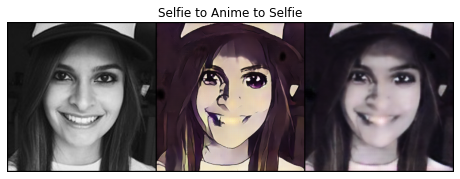

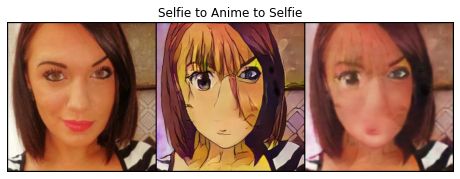

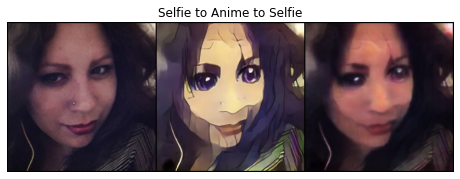

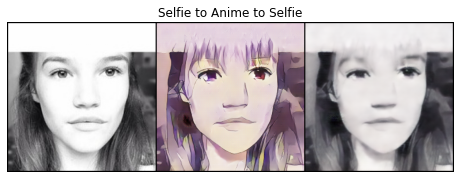

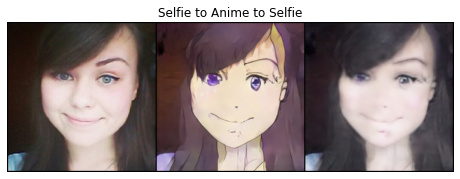

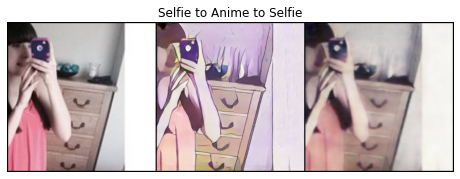

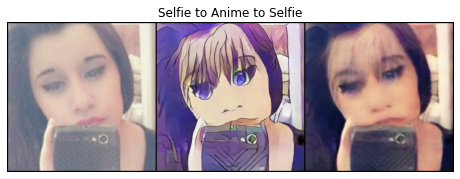

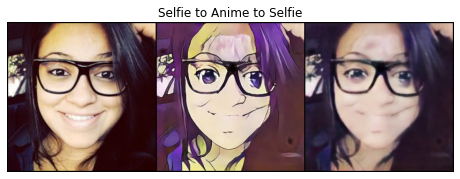

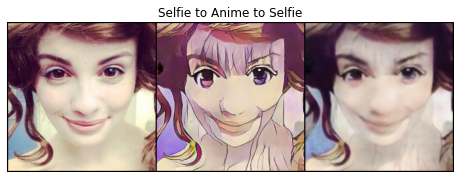

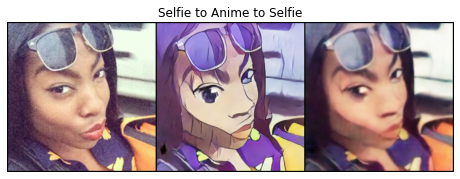

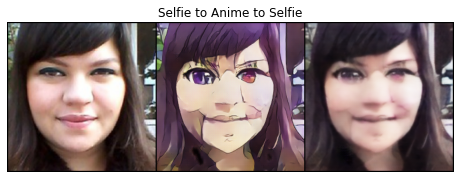

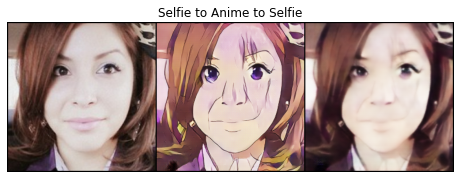

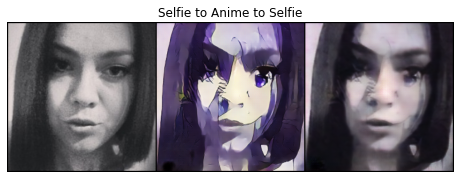

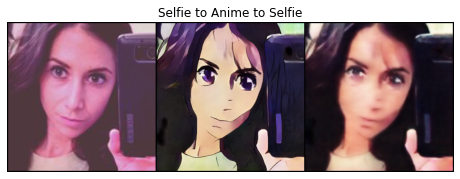

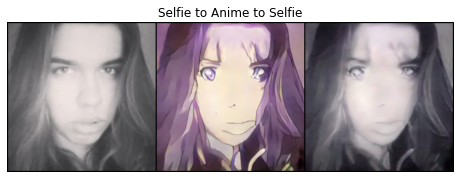

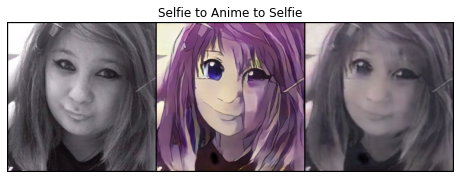

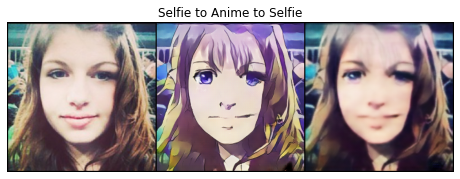

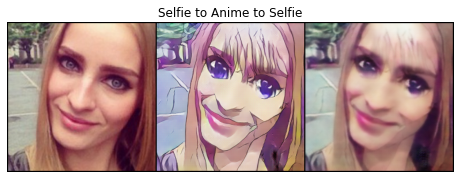

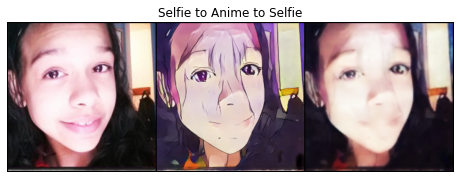

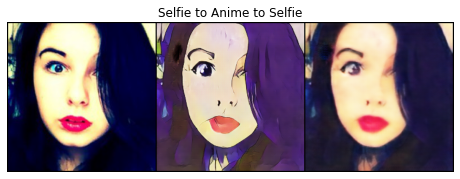

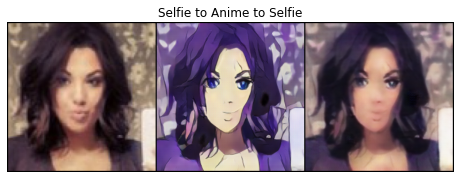

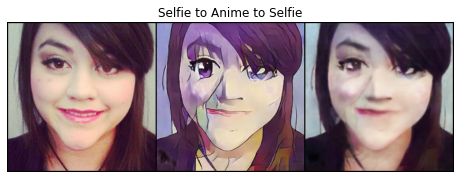

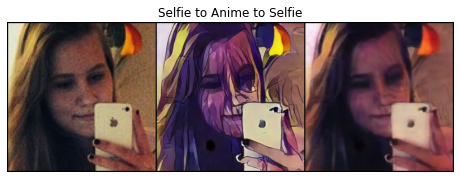

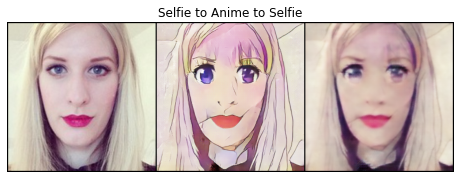

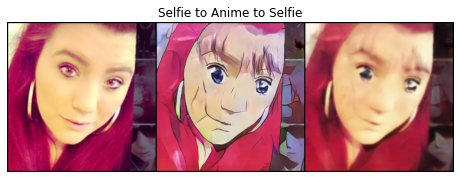

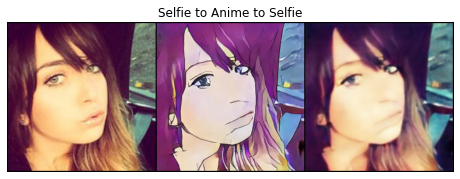

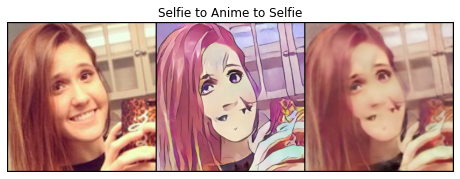

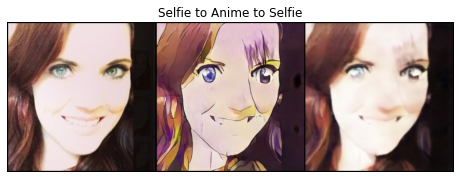

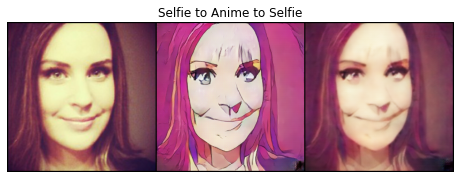

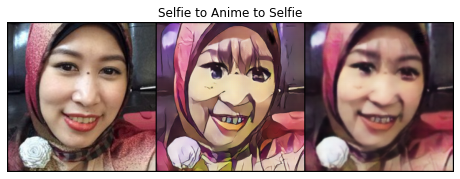

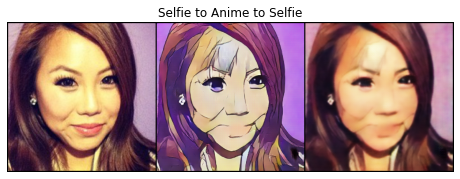

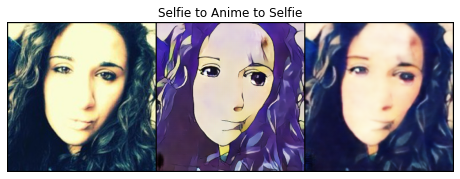

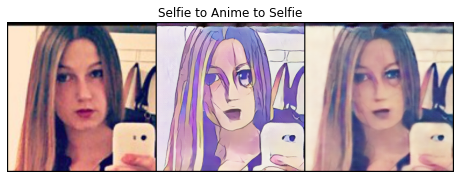

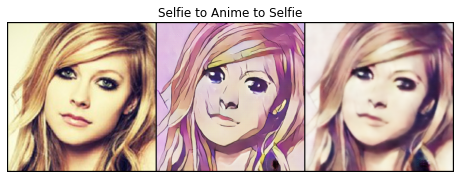

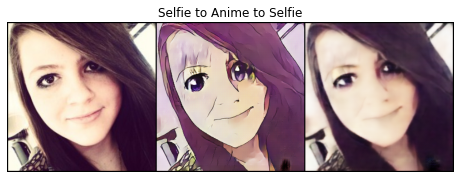

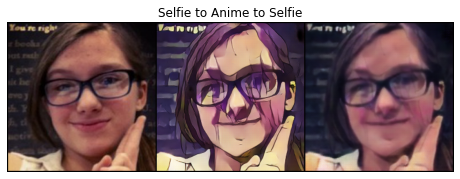

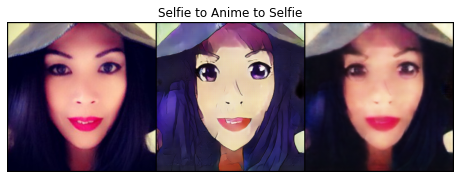

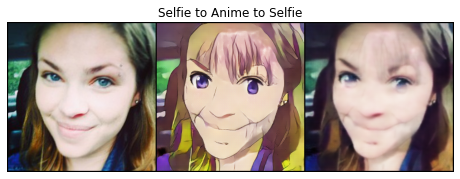

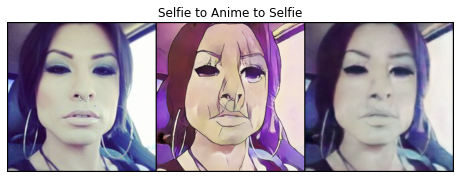

In [ ]:
# save test images

save_path = "/content/drive/MyDrive/Computer Vision/saved/Figures/"
epoch_plot(G_A, G_B, loader_testA, loader_testB, "Saving All", save_path, save_all=True)